296


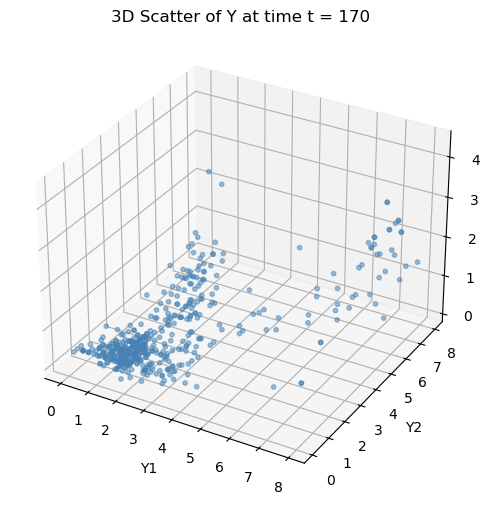

In [12]:
import torch, random, io, sys, warnings
import os, numpy as np, pandas as pd, pyreadr, matplotlib.pyplot as plt
from scipy.special import softmax
from data_generator import generate_gmm_data_segments
from tqdm import tqdm
from cpd_model import parse_args, learn_one_seq_penalty, evaluation


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


import pyreadr


Y = pyreadr.read_r("../y_arr.rds")
X = pyreadr.read_r("../x_arr.rds")
W = pyreadr.read_r("../weight_arr.rds")

Y_df = np.array(list(Y.values())[0])
X_df = np.array(list(X.values())[0])
W_df = np.array(list(W.values())[0])

Y = Y_df
X = X_df
W = W_df

T = Y_df.shape[0]
print(T)


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

t = 170
Y_t = Y[t]  # N × 3

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(Y_t[:, 0], Y_t[:, 1], Y_t[:, 2],
           c="steelblue", alpha=0.5, s=10)

ax.set_xlabel("Y1")
ax.set_ylabel("Y2")
ax.set_zlabel("Y3")
ax.set_title(f"3D Scatter of Y at time t = {t}")

plt.show()




[INFO] Using device: cuda
Epoch   5 | Loss=902.273315 | Kurtosis=51.691795
Epoch  10 | Loss=606.799805 | Kurtosis=38.528957
Epoch  15 | Loss=572.603394 | Kurtosis=50.882526
Epoch  20 | Loss=566.295776 | Kurtosis=68.997925
Epoch  25 | Loss=562.791931 | Kurtosis=82.716888
Epoch  30 | Loss=563.325012 | Kurtosis=89.278168
Epoch  35 | Loss=560.637756 | Kurtosis=91.055763
Epoch  40 | Loss=558.842957 | Kurtosis=96.637474
Epoch  45 | Loss=561.220886 | Kurtosis=96.303596
Epoch  50 | Loss=556.811707 | Kurtosis=95.781540
Epoch  55 | Loss=554.864258 | Kurtosis=97.993652
Epoch  60 | Loss=560.375977 | Kurtosis=98.671593
Epoch  65 | Loss=554.450684 | Kurtosis=97.249687
Epoch  70 | Loss=552.722961 | Kurtosis=94.256706
Epoch  75 | Loss=559.443665 | Kurtosis=91.867783
Epoch  80 | Loss=552.582336 | Kurtosis=91.571243
Epoch  85 | Loss=550.727234 | Kurtosis=89.981346
Epoch  90 | Loss=558.450562 | Kurtosis=85.726913
Epoch  95 | Loss=550.316284 | Kurtosis=87.205261
Epoch 100 | Loss=548.669800 | Kurtosis=87.0

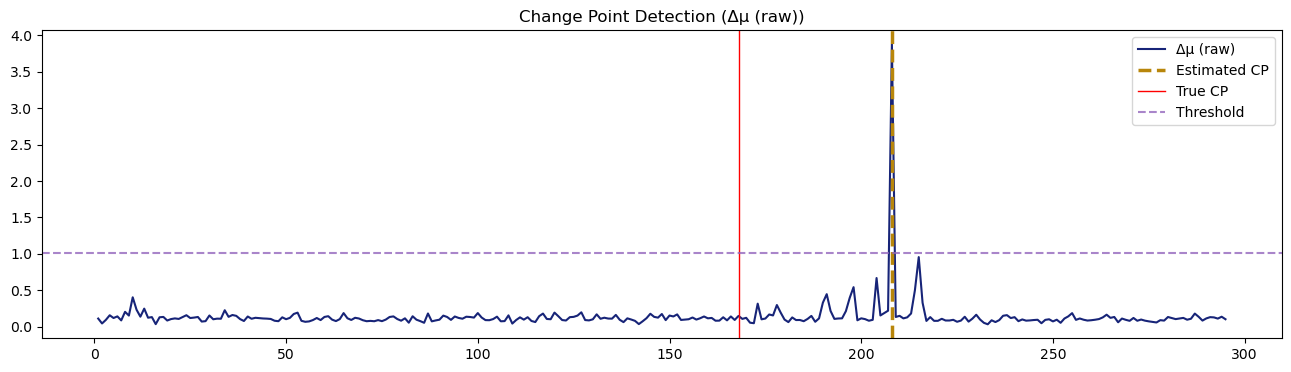

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ======================================================
# 7. Prepare args
# ======================================================
 
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
    
args = parse_args()
args.epoch = 200
args.K_dim = 15
args.z_dim = 5
args.x_dim = X.shape[2]
args.y_dim = Y.shape[2]
args.num_time = X.shape[0]
args.num_samples = X.shape[1]
args.decoder_lr = 0.001
args.decoder_iteration = 10
args.langevin_s = 0.2
args.langevin_K = 200
args.kappa = 0.8
args.penalties = [0.01, 0.05, 0.1, 1]
args.nu_iteration = 10
args.output_layer = [50, 50]
args.scale_delta = False
args.signif_level = 0.9999
args.true_CP_full = [168]

# ======================================================
# 8. Prepare data tensors
# ======================================================

T, N, p = X.shape
_, _, d = Y.shape


X_flat = X.reshape(T * N, p)
Y_flat = Y.reshape(T * N, d)

x_input = torch.tensor(X_flat, dtype=torch.float32, device=device)
y_input = torch.tensor(Y_flat, dtype=torch.float32, device=device)

# ---- weights: KEEP (T,N), do NOT flatten here ----
w_input = torch.tensor(W, dtype=torch.float32, device=device)


odd_idx  = torch.arange(1, T, 2)
even_idx = torch.arange(0, T, 2)

# ---- X / Y ----
x_train = X[odd_idx].reshape(-1, p)
y_train = Y[odd_idx].reshape(-1, d)
x_test  = X[even_idx].reshape(-1, p)
y_test  = Y[even_idx].reshape(-1, d)

# ---- weights ----
w_train = W[odd_idx]     # (T_train, N)
w_test  = W[even_idx]   # (T_test, N)

x_train = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
x_test  = torch.tensor(x_test,  dtype=torch.float32, device=device)
y_test  = torch.tensor(y_test,  dtype=torch.float32, device=device)

w_train = torch.tensor(w_train, dtype=torch.float32, device=device)
w_test  = torch.tensor(w_test,  dtype=torch.float32, device=device)



results_half = []
for penalty in args.penalties:
    loss, pen = learn_one_seq_penalty(
        args,
        x_train, y_train,
        x_test, y_test,
        penalty=penalty,
        half=True,
        weights_train=None,
        weights_test=None,
    )
    results_half.append([loss, pen])

results_half = np.array(results_half)

best_idx = np.argmin(results_half[:, 0])
best_penalty = results_half[best_idx, 1]

print(f"\n[INFO] Best penalty selected = {best_penalty}\n")


result, kurt_list, delta_mu_all, best_mu, best_model_state = learn_one_seq_penalty(
    args=args,
    x_input_train=x_input,
    y_input_train=y_input,
    x_input_test=x_input,     # dummy, not used when half=False
    y_input_test=y_input,
    penalty=best_penalty,
    half=False,
    weights_train=None,
    weights_test=None,
)

torch.cuda.empty_cache()



# NICE RESULT
# penalty=0.1
# args = parse_args()
# args.epoch = 100
# args.K_dim = 15
# args.z_dim = 5
# args.x_dim = X.shape[2]
# args.y_dim = Y.shape[2]
# args.num_time = X.shape[0]
# args.num_samples = X.shape[1]
# args.decoder_lr = 0.001
# args.decoder_iteration = 10
# args.langevin_s = 0.1
# args.langevin_K = 200
# args.kappa = 0.8
# args.penalties = [0.01, 0.05, 0.1, 1]
# args.nu_iteration = 20
# args.output_layer = [50, 50]
# args.scale_delta = False
# args.signif_level = 0.9999
# args.true_CP_full = [168]


# args.epoch = 100
# args.K_dim = 15
# args.z_dim = 5
# args.x_dim = X.shape[2]
# args.y_dim = Y.shape[2]
# args.num_time = X.shape[0]
# args.num_samples = X.shape[1]
# args.decoder_lr = 0.001
# args.decoder_iteration = 20
# args.langevin_s = 0.2
# args.langevin_K = 200
# args.kappa = 0.8
# args.penalties = [0.01, 0.05, 0.1, 1]
# args.nu_iteration = 20
# args.output_layer = [50, 50]
# args.scale_delta = False
# args.signif_level = 0.9999
# args.true_CP_full = [168]



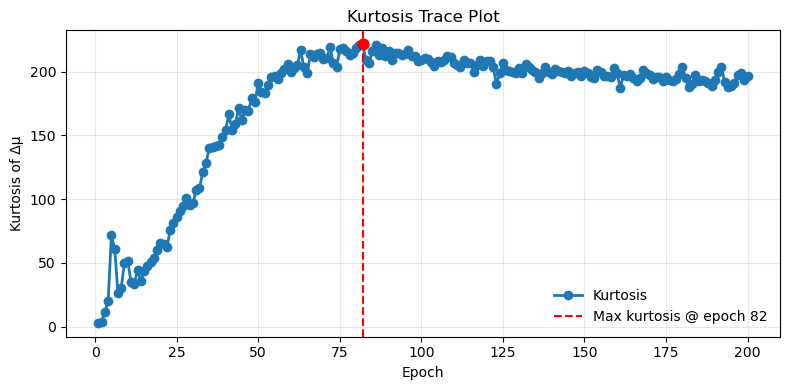

[INFO] Best epoch = 82, Kurtosis = 221.502228


In [16]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(kurt_list) + 1)
best_idx = int(np.argmax(kurt_list))
best_kurt = kurt_list[best_idx]

plt.figure(figsize=(8, 4))
plt.plot(epochs, kurt_list, lw=2, marker='o', label="Kurtosis")
plt.axvline(best_idx + 1, color="red", linestyle="--", lw=1.5,
            label=f"Max kurtosis @ epoch {best_idx + 1}")
plt.scatter(best_idx + 1, best_kurt, color="red", s=60, zorder=5)

plt.xlabel("Epoch")
plt.ylabel("Kurtosis of Δμ")
plt.title("Kurtosis Trace Plot")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"[INFO] Best epoch = {best_idx + 1}, Kurtosis = {best_kurt:.6f}")


Loaded 296 timestamps.


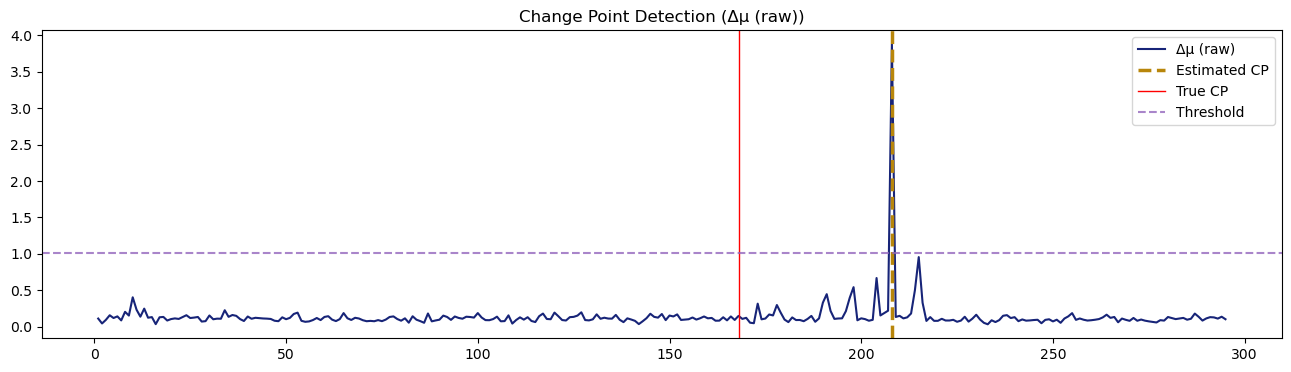

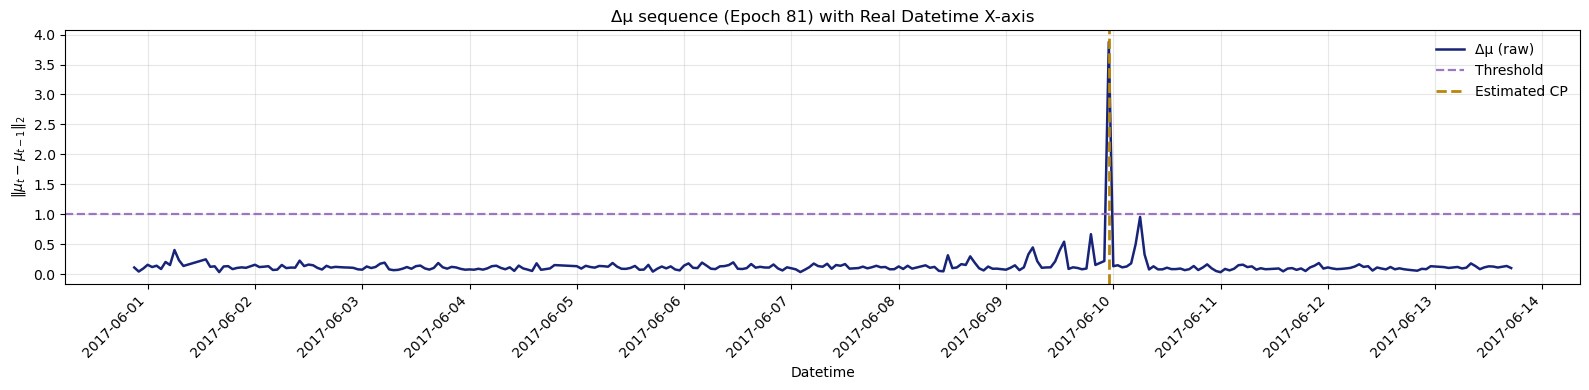

In [17]:
epoch_i = 81
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyreadr

# ----------------------------
# 1. Read Rnames from RDS
# ----------------------------
Rnames = pyreadr.read_r("../datetime.rds")

Rnames_df = list(Rnames.values())[0]          # shape = (T, 1)
Rtimes = pd.to_datetime(Rnames_df.iloc[:, 0]) # convert to datetime list
Rtimes = np.array(Rtimes)                     # length T

print(f"Loaded {len(Rtimes)} timestamps.")



delta_mu_i = delta_mu_all[epoch_i]            # length = T−1
T = len(delta_mu_i) + 1
time_labels = Rtimes[1:T]                     # length T−1

assert len(time_labels) == len(delta_mu_i), \
    f"Mismatch: {len(time_labels)} labels vs {len(delta_mu_i)} Δμ"


# ----------------------------
# 3. Compute CP results
# ----------------------------
abs_error, dist_est_gt, dist_gt_est, cover, threshold, est_CP, fig_tmp = \
    evaluation(delta_mu_i, args)


# ----------------------------
# 4. Plot with REAL datetime x-axis
# ----------------------------
plt.figure(figsize=(16, 4))

# Δμ curve
plt.plot(time_labels, delta_mu_i,
         lw=1.8, color="#172478", label="Δμ (raw)")


# Threshold line
plt.axhline(threshold, color="#9467bd",
            linestyle="--", lw=1.6, alpha=0.9,
            label="Threshold")


# Estimated CPs (use real datetime)
for cp in est_CP:
    plt.axvline(Rtimes[cp], color="#B8860B",
                linestyle="--", lw=2,
                label="Estimated CP")


# True CPs
# if hasattr(args, "true_CP_full"):
#     for cp in args.true_CP_full:
#         plt.axvline(Rtimes[cp], color="red",
#                     linestyle="-", lw=1.3,
#                     label="True CP")


# ----------------------------
# 5. Format x-axis: show every day
# ----------------------------
ax = plt.gca()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) 

plt.xticks(rotation=45, ha='right')


# ----------------------------
# 6. Cleaning legend
# ----------------------------
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), frameon=False, loc="upper right")


# ----------------------------
# 7. Title and labels
# ----------------------------
plt.title(f"Δμ sequence (Epoch {epoch_i}) with Real Datetime X-axis")
plt.ylabel(r"$\|\mu_t - \mu_{t-1}\|_2$")
plt.xlabel("Datetime")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


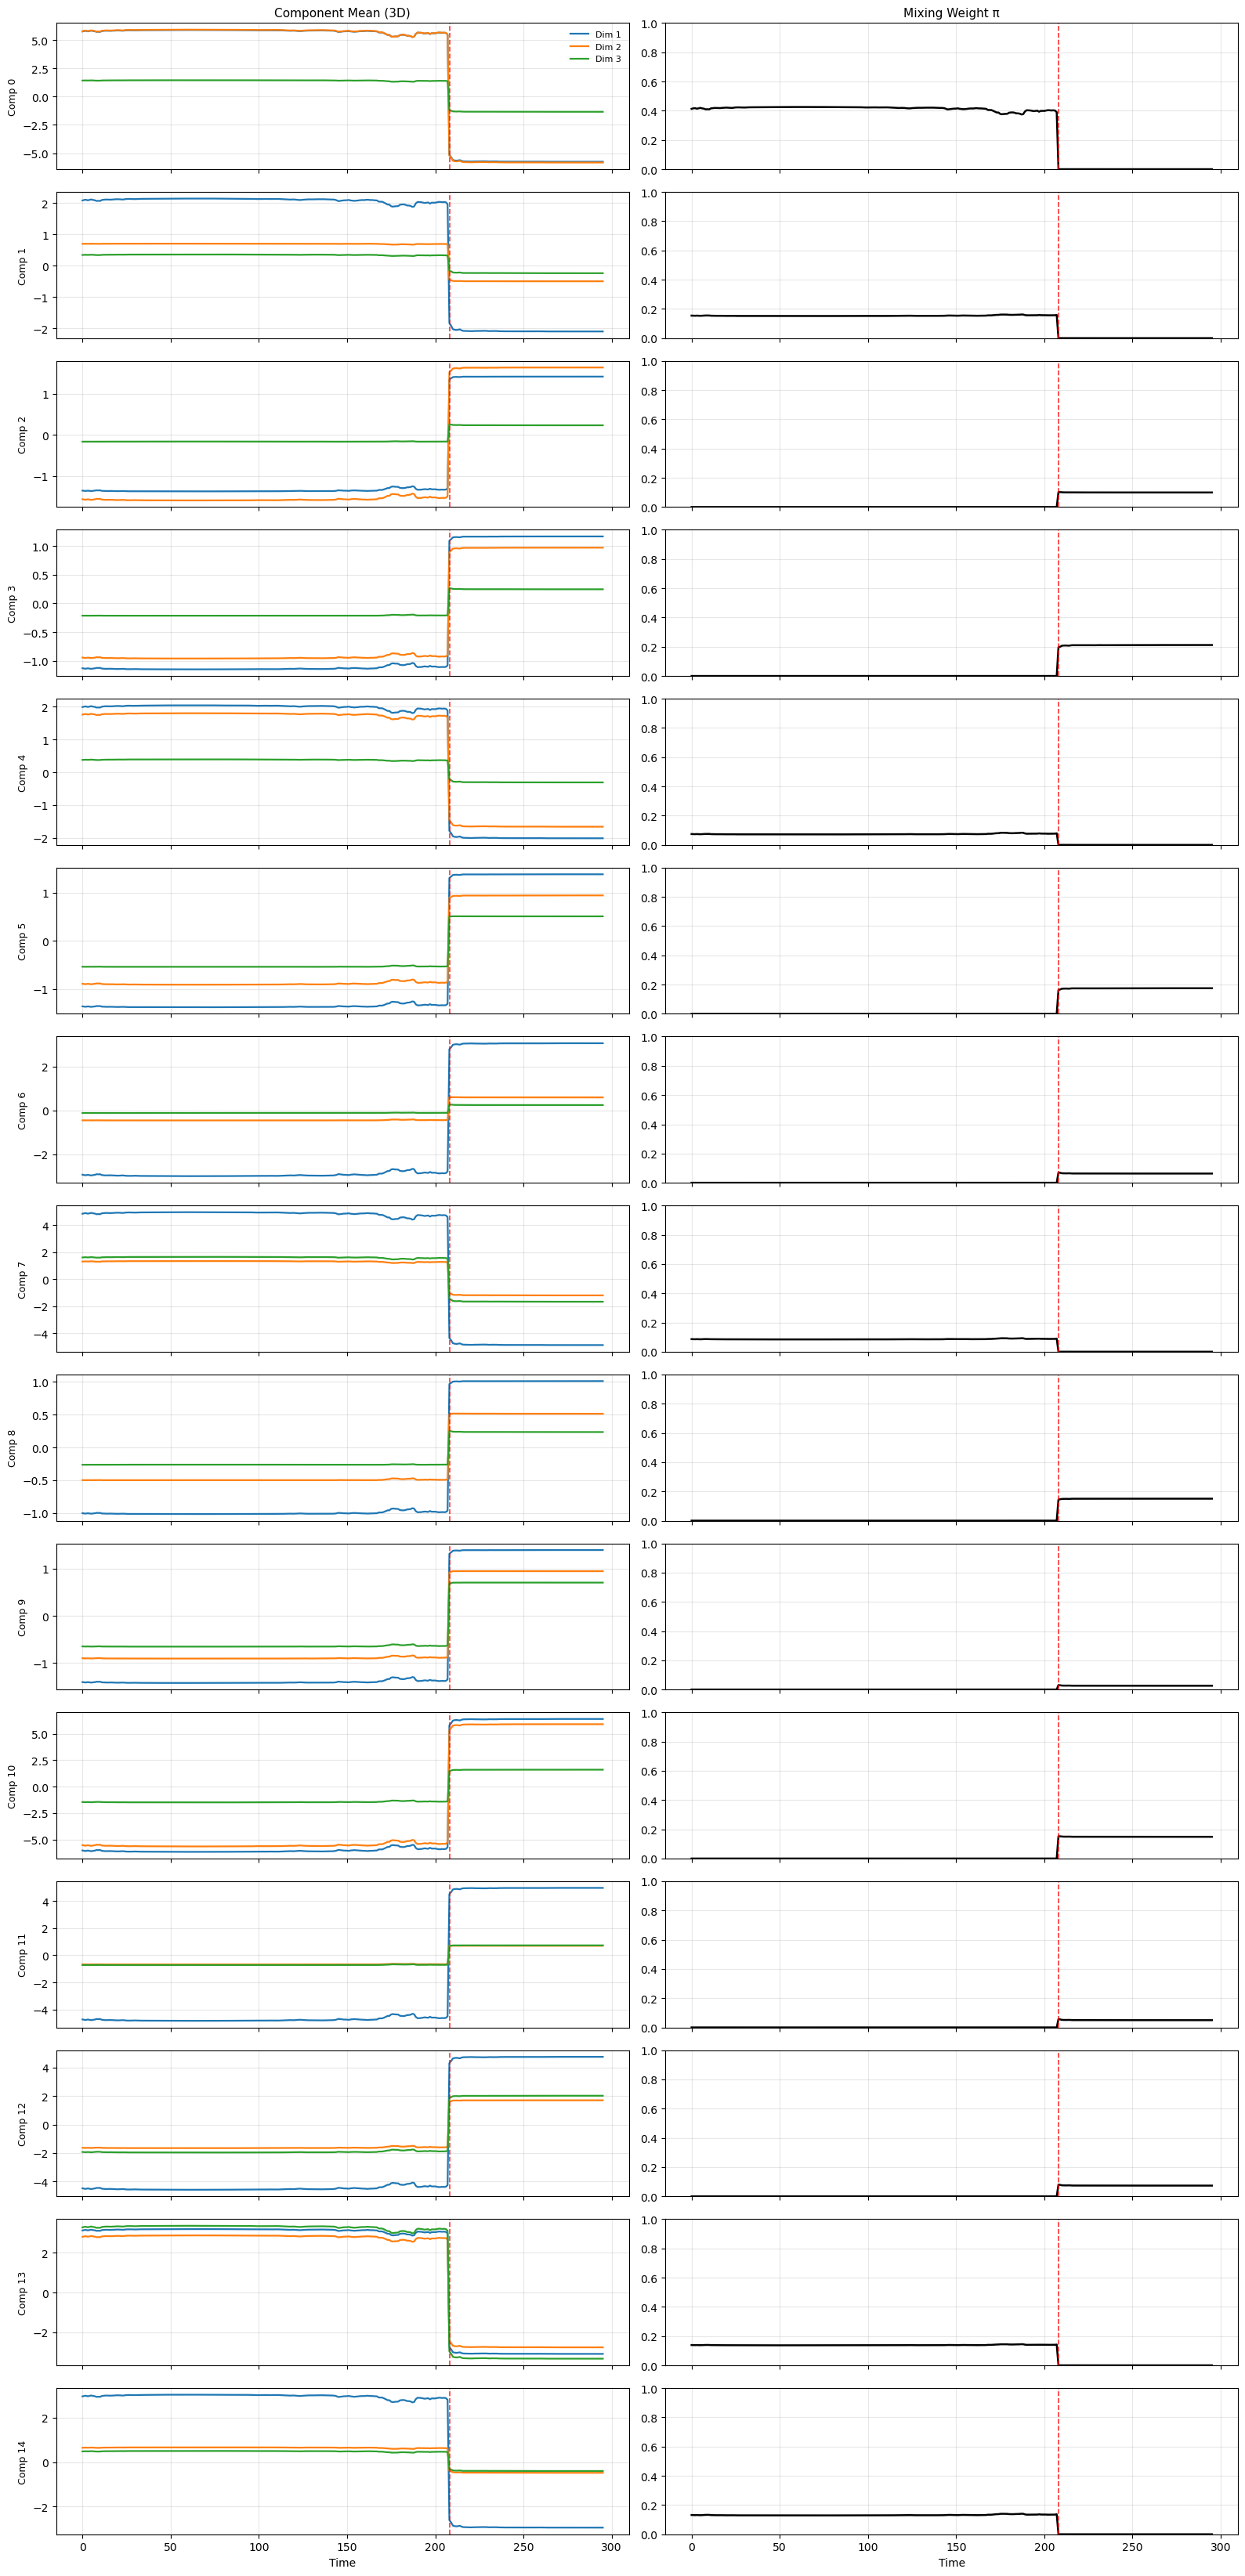

In [7]:
from cpd_model import CPD, parse_args, learn_one_seq_penalty

model = CPD(args, half=False).to(device)
model.load_state_dict(best_model_state)
T = args.num_time
N = args.num_samples
p = args.x_dim

x_t = x_input.view(T, N, p)[:, 0, :]
with torch.no_grad():
    pi_t, mean_t, _ = model(x_t, best_mu)

# shapes:
# mean_t : (T, K, 3)
# pi_t   : (T, K)

mean_t = mean_t.cpu().numpy()
pi_t   = pi_t.cpu().numpy()
import matplotlib.pyplot as plt
import numpy as np

K = args.K_dim
T = mean_t.shape[0]
time = np.arange(T)

fig, axes = plt.subplots(
    nrows=K,
    ncols=2,
    figsize=(16, 2.2 * K),
    sharex=True
)

if K == 1:
    axes = axes.reshape(1, 2)

true_cps = getattr(args, "true_CP_full", [])

for k in range(K):

    # ===== LEFT: 3D mean trajectories =====
    ax_mean = axes[k, 0]
    ax_mean.plot(time, mean_t[:, k, 0], label="Dim 1", lw=1.6)
    ax_mean.plot(time, mean_t[:, k, 1], label="Dim 2", lw=1.6)
    ax_mean.plot(time, mean_t[:, k, 2], label="Dim 3", lw=1.6)

    for cp in est_CP:
        ax_mean.axvline(cp, color="red", linestyle="--", lw=1.2, alpha=0.8)

    ax_mean.set_ylabel(f"Comp {k}", fontsize=9)
    if k == 0:
        ax_mean.set_title("Component Mean (3D)", fontsize=11)
        ax_mean.legend(frameon=False, fontsize=8, loc="upper right")

    ax_mean.grid(alpha=0.3)

    # ===== RIGHT: pi trajectory =====
    ax_pi = axes[k, 1]
    ax_pi.plot(time, pi_t[:, k], color="black", lw=1.8)

    for cp in est_CP:
        ax_pi.axvline(cp, color="red", linestyle="--", lw=1.2, alpha=0.8)

    if k == 0:
        ax_pi.set_title("Mixing Weight π", fontsize=11)

    ax_pi.set_ylim(0, 1)
    ax_pi.grid(alpha=0.3)

# x-label only on bottom
axes[-1, 0].set_xlabel("Time")
axes[-1, 1].set_xlabel("Time")

plt.tight_layout()
plt.show()





In [18]:
save_dict = {
    "best_mu": best_mu.cpu(),                     # Tensor (T, d)
    "best_model_state": best_model_state,         # state_dict (CPU)
    "kurt_list": kurt_list,                       # list of float
    "delta_mu_all": delta_mu_all,                 # list of np.array
    "result": result,                             # tuple
    "args": vars(args),                           # argparse -> dict
}

torch.save(save_dict, "cpd_results.pt")

print("[INFO] Results saved to cpd_results.pt")


[INFO] Results saved to cpd_results.pt


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_5x3(mean_t, true_cps=None, savepath=None):
    """
    mean_t: (T, 15, 3)
    true_cps: list of CP indices
    """

    T, K, D = mean_t.shape
    assert K == 15 and D == 3

    time = np.arange(T)

    fig, axes = plt.subplots(
        nrows=5,
        ncols=3,
        figsize=(16, 12),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()

    for k in range(15):
        ax = axes[k]

        ax.plot(time, mean_t[:, k, 0], lw=1.4, label="Dim 1")
        ax.plot(time, mean_t[:, k, 1], lw=1.4, label="Dim 2")
        ax.plot(time, mean_t[:, k, 2], lw=1.4, label="Dim 3")

        if true_cps is not None:
            for cp in est_CP:
                ax.axvline(
                    cp,
                    color="red",
                    linestyle="--",
                    lw=1.2,
                    alpha=0.9,
                    label="Change Point" if k == 0 else None
                )

        ax.set_title(f"Component {k+1}", fontsize=10)
        ax.grid(alpha=0.3)

        # legend only once
        if k == 0:
            ax.legend(frameon=False, fontsize=9)

    # common labels
    fig.text(0.5, 0.04, "Time", ha="center", fontsize=11)
    fig.text(0.04, 0.5, "Mean value", va="center",
             rotation="vertical", fontsize=11)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])

    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")
        print(f"[INFO] Saved mean plot to {savepath}")

    plt.show()


In [2]:
plot_mean_5x3(
    mean_t,
    true_cps=args.true_CP_full,
    savepath="mean_components_5x3.pdf"
)

NameError: name 'mean_t' is not defined

In [21]:
def plot_pi_5x3(pi_t, true_cps=None, savepath=None):
    """
    pi_t: (T, 15)
    true_cps: list of CP indices
    """

    T, K = pi_t.shape
    assert K == 15

    time = np.arange(T)

    fig, axes = plt.subplots(
        nrows=5,
        ncols=3,
        figsize=(16, 12),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()

    for k in range(15):
        ax = axes[k]

        ax.plot(time, pi_t[:, k], color="black", lw=1.6, label="Mixing weight")

        if true_cps is not None:
            for cp in est_CP:
                ax.axvline(
                    cp,
                    color="red",
                    linestyle="--",
                    lw=1.2,
                    alpha=0.9,
                    label="Change Point" if k == 0 else None
                )

        ax.set_ylim(0, 1)
        ax.set_title(f"Component {k+1}", fontsize=10)
        ax.grid(alpha=0.3)

        # legend only once
        if k == 0:
            ax.legend(frameon=False, fontsize=9)

    # common labels
    fig.text(0.5, 0.04, "Time", ha="center", fontsize=11)
    fig.text(0.04, 0.5, "Mixing weight π", va="center",
             rotation="vertical", fontsize=11)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])

    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")
        print(f"[INFO] Saved pi plot to {savepath}")

    plt.show()


[INFO] Saved pi plot to pi_components_5x3.pdf


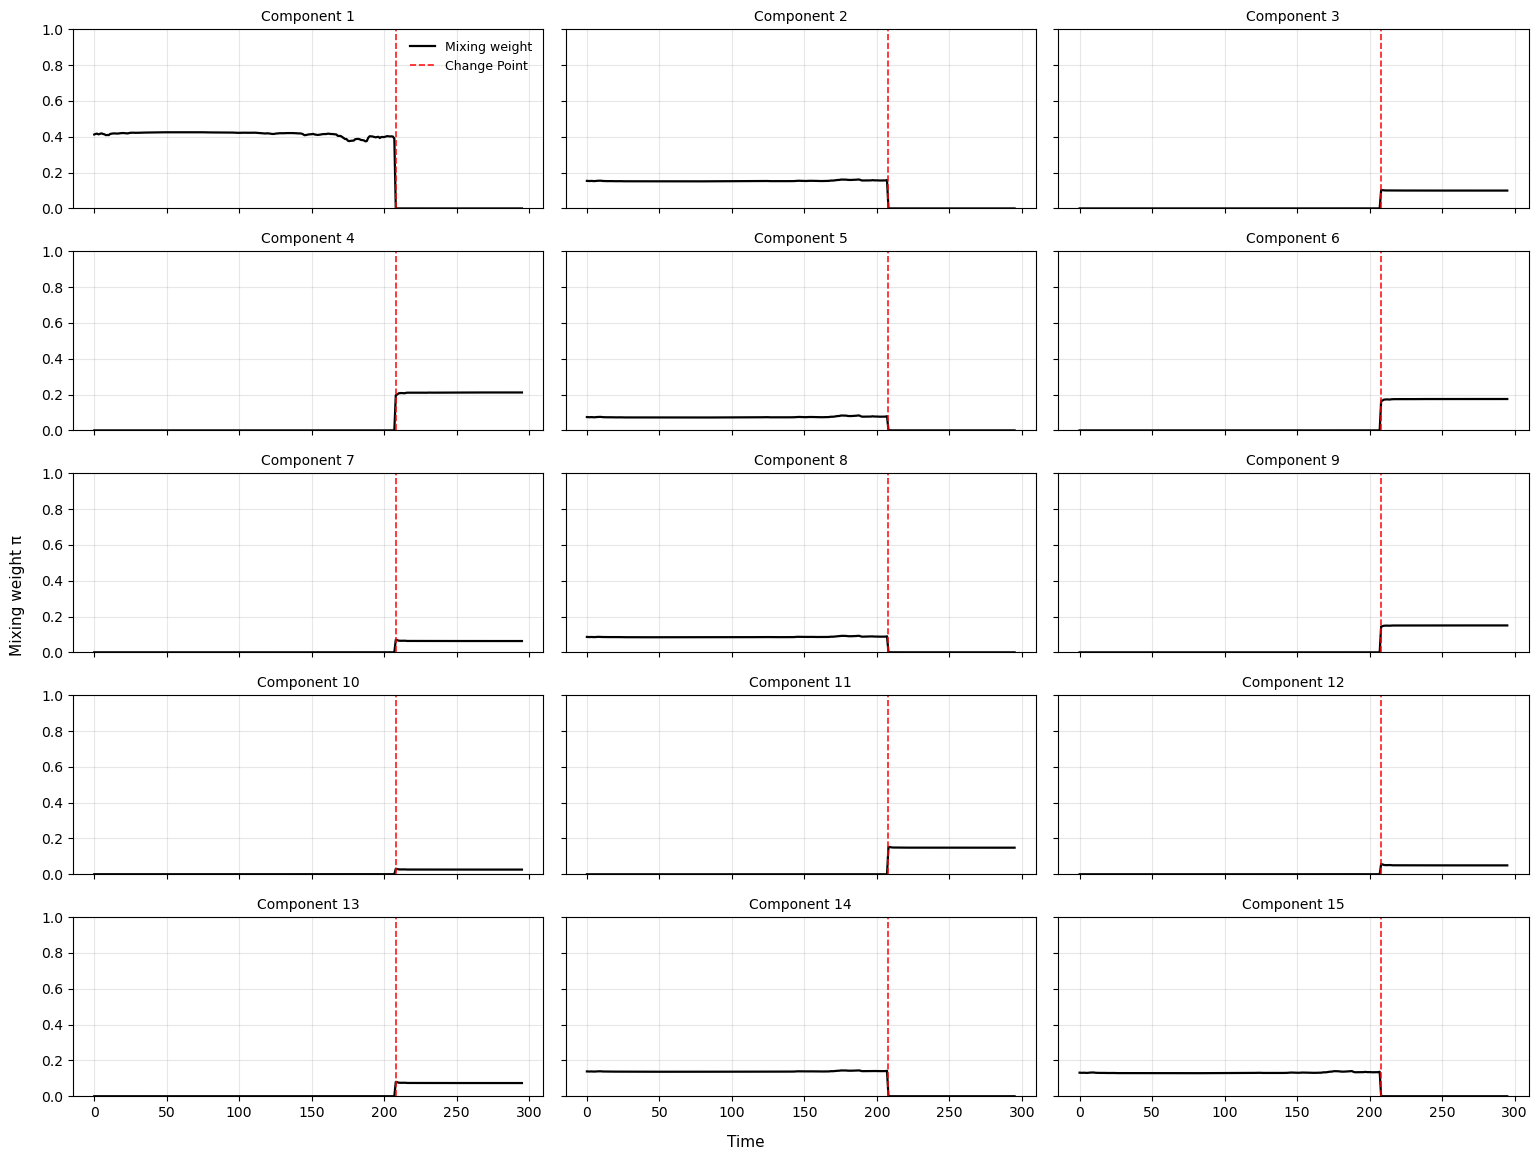

In [22]:
plot_pi_5x3(
    pi_t,
    true_cps=args.true_CP_full,
    savepath="pi_components_5x3.pdf"
)


In [8]:
est_CP

[208]

In [22]:
import pandas as pd

df = pd.DataFrame({
    "time": time_labels,
    "delta_mu": delta_mu_i
})

df.to_csv("delta_mu_with_time.csv", index=False)